In [197]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json

import scanpy
import anndata
import bbknn

# bbknn.bbknn(adata)

from tqdm import tqdm

In [198]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")

chromosome = 'chrY'


In [199]:
data_gtf = pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key = 'gtf')
# data_gtf = data_gtf.loc[data_gtf['seqname'] == chromosome]

data_header = pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key='header')

data_geuvadis =  pd.read_hdf(fdir_processed / f'geuvadis.preprocessed.h5', key = 'geuvadis')
# data_geuvadis = data_geuvadis[data_gtf.index]

# data_geuvadis['sex'] =  data_header.loc[data_geuvadis.index, 'Sex']
# data_geuvadis

adata = anndata.AnnData(X=data_geuvadis, 
                        var=data_gtf.loc[data_geuvadis.columns], 
                        obs=data_header.loc[data_geuvadis.index]) 

In [200]:
columns = []
for column in adata.obs.columns:
    length = len(adata.obs[column].unique())
    if 1 < length < 10:
        columns.append(column)
        print(column)

AvgSpotLen
Center Name
DATASTORE filetype
ENA-FIRST-PUBLIC (run)
Experimental_Factor:_laboratory (exp)
Experimental_Factor:_population (exp)
INSDC_first_public
population
ReleaseDate
version
Sex


In [201]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(adata[:, adata.var['seqname'] == 'chrY'].X)


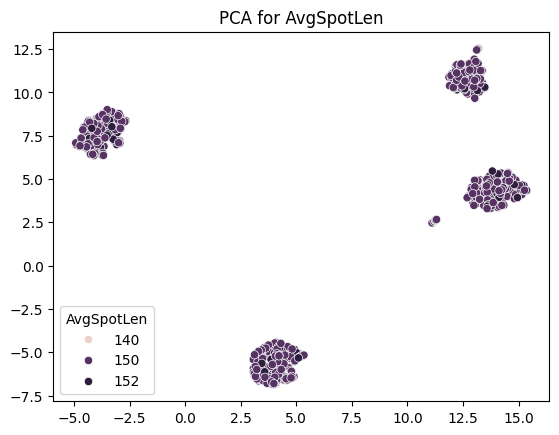

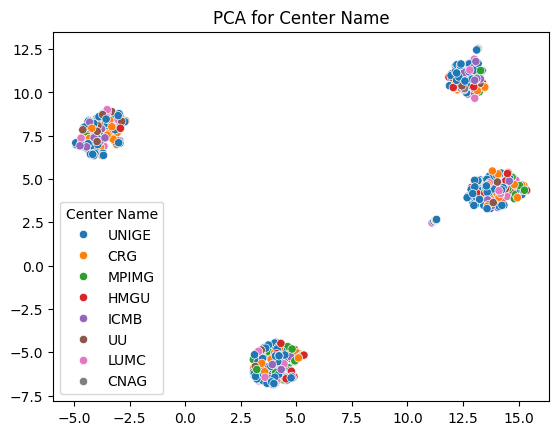

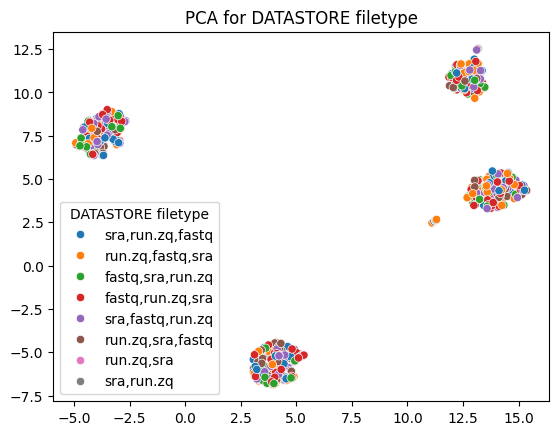

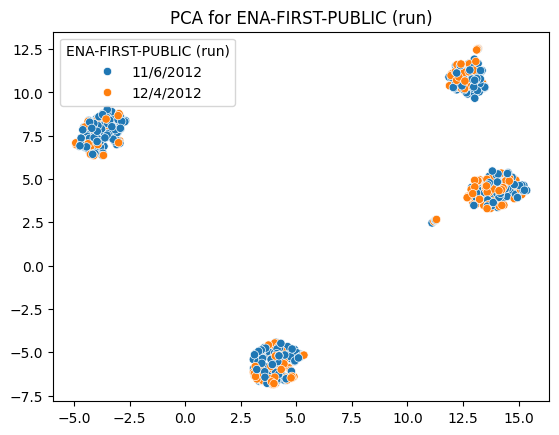

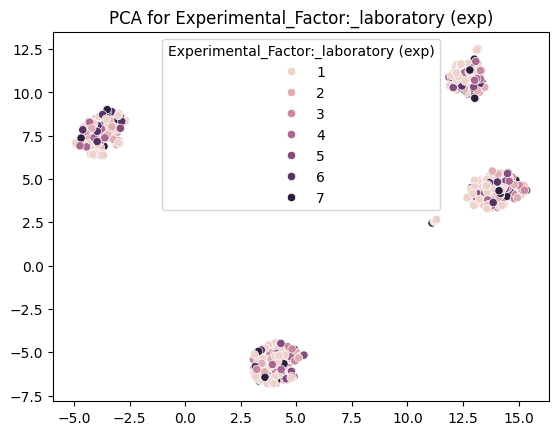

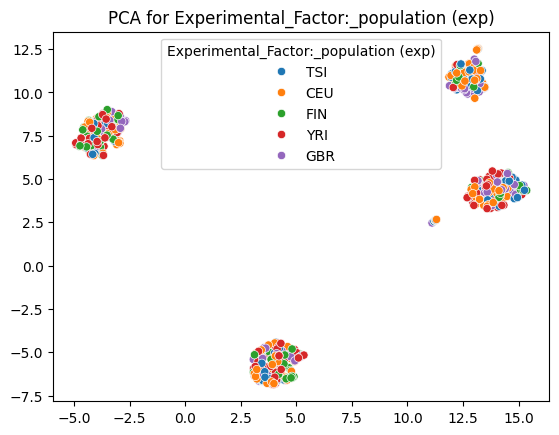

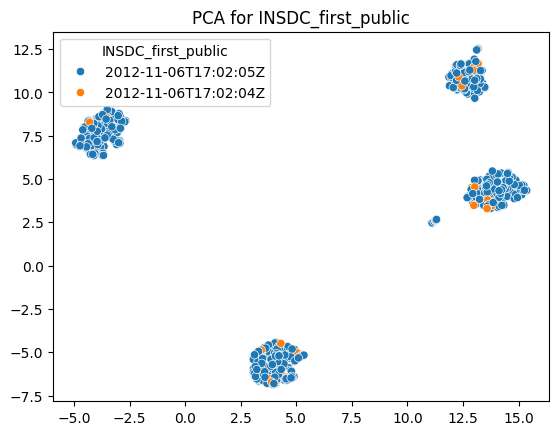

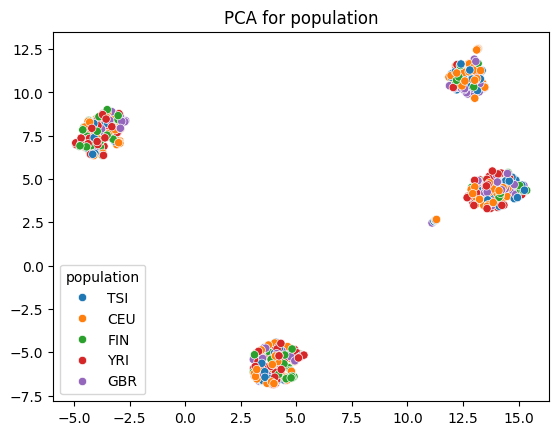

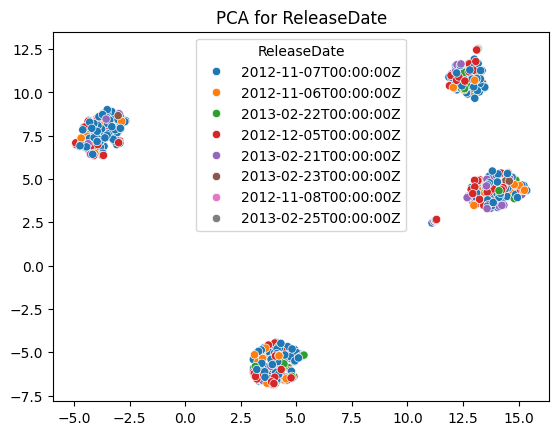

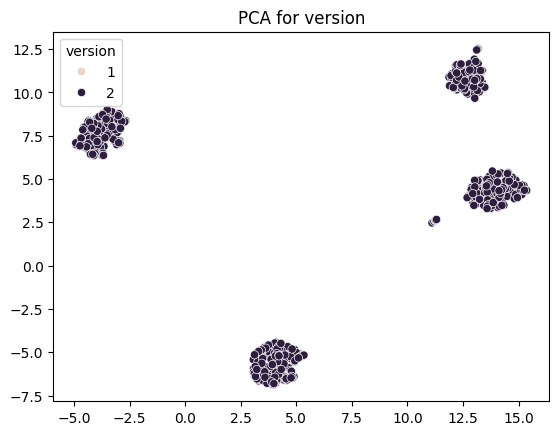

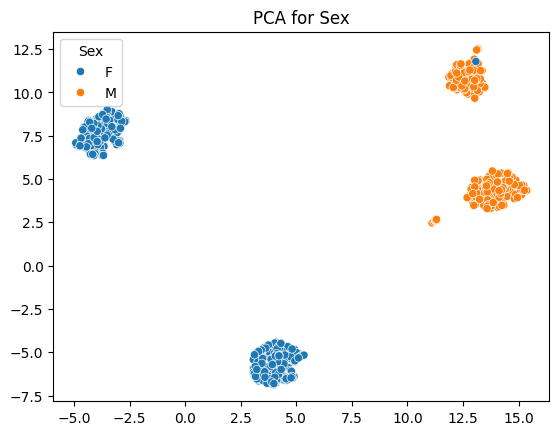

In [202]:
for c in columns:
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=adata.obs[c]
        # hue=adata.obs['Sample_name'].str[:-5]
    )
    plt.title(f'PCA for {c}')
    plt.show()

Text(0.5, 1.0, 'PCA for chrY')

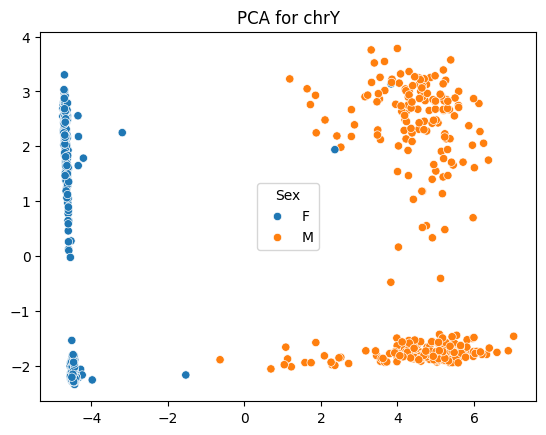

In [204]:
# reducer = umap.UMAP()
reducer = PCA(2)
embedding = reducer.fit_transform(
    adata[:, adata.var['seqname'] == chromosome].X
    # adata.X
)

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=adata.obs['Sex']
    # hue=clusters.labels_
)
plt.title(f'PCA for {chromosome}')


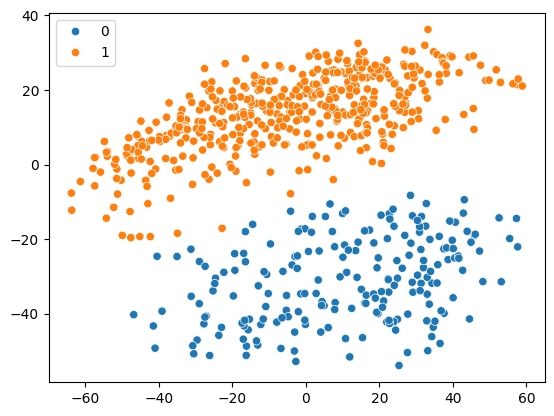

In [210]:
from sklearn.cluster import KMeans, DBSCAN

reducer = PCA(2)
embedding = reducer.fit_transform(
    adata.X)

clusters = KMeans(2).fit(embedding)
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=clusters.labels_,
    palette='tab10'
)
plt.show()

In [205]:
adata.layers['normalized']  = StandardScaler().fit_transform(adata.X)
adata_chrY = adata[:, adata.var['seqname'] == 'chrY']

Text(0.5, 1.0, 'PCA for chrY')

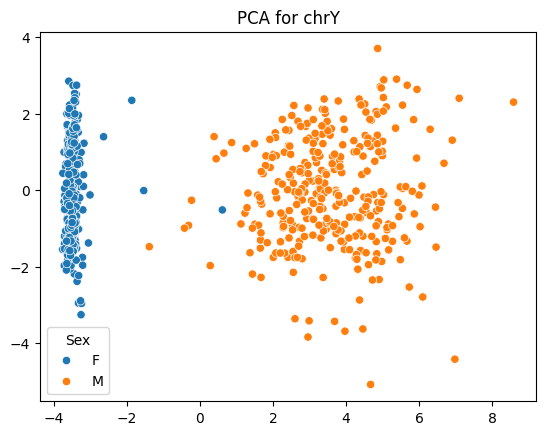

In [214]:
reducer = PCA(2)
embedding = reducer.fit_transform(
    adata_chrY.layers['normalized']
    # adata.X
)

sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=adata_chrY.obs['Sex']
    # hue=clusters.labels_
)
plt.title(f'PCA for {chromosome}')

<Axes: xlabel='value', ylabel='Count'>

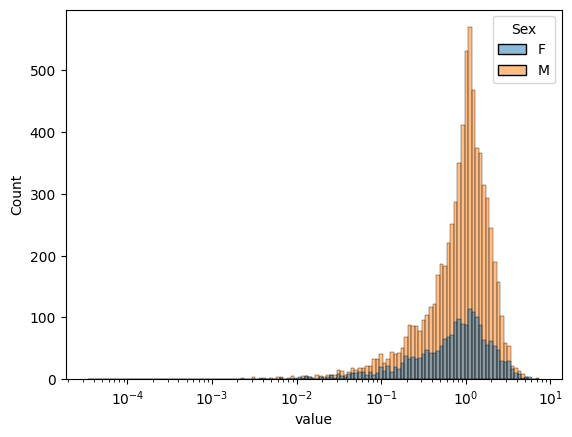

In [206]:
data_chrY = adata_chrY.to_df(layer='normalized')
data_chrY['Sex'] = adata.obs['Sex']

sns.histplot(data_chrY.melt('Sex'), x='value', hue='Sex', log_scale=True)


In [207]:
pseudoautosoms_Y1 = [10001, 2781479]
pseudoautosoms_X1 = [10001, 2781479]
pseudoautosoms_Y2 = [56887903, 57217415]
pseudoautosoms_X2 = [155701383, 156030895]

pseudoauto = adata_chrY[:, 
                        ((adata_chrY.var["start"] > pseudoautosoms_Y1[0]) & 
                        (adata_chrY.var["end"] < pseudoautosoms_Y1[1])) |
                        ((adata_chrY.var["start"] > pseudoautosoms_Y2[0]) & 
                        (adata_chrY.var["end"] < pseudoautosoms_Y2[1]))
                        ]

pseudoauto.to_df()

,MSTRG.36690.8,MSTRG.36691.6,MSTRG.36702.6,ENST00000711210.1,MSTRG.36705.7,MSTRG.36705.21,ENST00000711197.1,MSTRG.36701.2,ENST00000711235.1,ENST00000711237.1,MSTRG.36708.10,MSTRG.36706.2,ENST00000711159.1,ENST00000711154.1,ENST00000711151.1,ENST00000711264.1
ERR188021,0.298357,0.186729,0.003915,0.000000,0.000000,0.849876,0.201128,0.003828,1.216267,0.098222,0.181893,1.006452,0.000000,0.387026,0.125729,0.317747
ERR188022,0.391138,0.248443,0.034692,0.000000,1.400249,0.791706,0.000000,0.141921,1.650085,0.094308,0.420963,0.000000,0.629936,0.111879,0.521427,0.335822
ERR188023,0.386376,0.887412,1.850737,0.645902,0.058217,0.000000,4.939532,0.234429,1.505354,0.047298,0.761579,0.619390,0.609949,0.099160,0.018530,0.136519
ERR188024,0.482428,1.482096,0.000000,0.000000,0.213939,0.000000,0.000000,0.188400,1.248135,0.225820,0.068020,0.185396,0.000000,0.000000,0.247344,0.293758
ERR188025,0.000000,0.320804,0.880653,0.583724,0.378604,0.000000,4.414067,0.029714,1.042062,0.047497,0.070789,0.000000,2.202585,0.000000,0.019303,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,2.967808,0.892686,2.390805,1.949501,1.710294,0.000000,0.000000,0.949932,0.000000,2.268825,0.000000,2.251692,2.733119,0.000000,1.450226,0.000000
ERR205020,0.000000,0.305973,0.098541,0.697163,0.231066,0.237954,0.000000,0.605161,1.114109,0.000000,0.653943,0.000000,0.000000,0.666603,0.175914,0.000000
ERR205021,0.124237,0.617045,0.056083,0.000000,0.683929,0.409254,0.289369,0.357930,1.836630,0.118623,0.000000,0.000000,0.954314,0.560058,0.505521,0.000000
ERR205022,0.514327,0.405389,0.046652,0.000000,0.000000,1.489940,0.267724,0.510294,0.000000,2.107804,0.433874,2.448610,0.000000,0.473575,0.000000,0.000000


In [208]:
adata_true_Y = adata_chrY[:, 
                          (adata_chrY.var["end"] < pseudoautosoms_Y1[0]) | 
                          ((adata_chrY.var["start"] > pseudoautosoms_Y1[1]) & (adata_chrY.var["end"] < pseudoautosoms_Y2[0])) |
                          (adata_chrY.var["start"] > pseudoautosoms_Y2[1]) 
                          ]
adata_true_Y.X.shape

(667, 20)

<Axes: xlabel='value', ylabel='Count'>

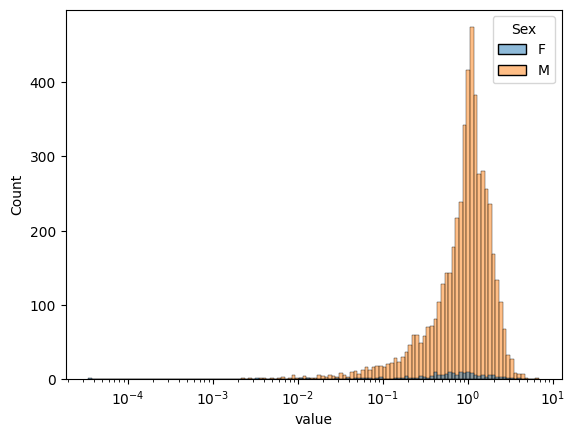

In [209]:
true_Y = adata_true_Y.to_df(layer='normalized')
true_Y['Sex'] = adata_true_Y.obs['Sex']
sns.histplot(true_Y.melt('Sex'), x='value', hue='Sex', log_scale=True)
